<a href="https://colab.research.google.com/github/jdariasl/ML_2020/blob/master/Labs/Extra/DespliegueModelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Despliegue de modelos

## Introducción

Recordar los pasos que habíamos visto en los estándares introducidos en [nuestra sesión](Basic_Preprocessing_FeatureEngineering.ipynb):

1. Entender problema y el objetivo
2. Obtener y Entender los datos (análisis exploratorio-- en algunas prácticas hemos iniciado con estas técnicas)
3. Modelar: incluyendo las transformaciones/ limpieza/ ingeniería de características de los datos y el modelo de ML (entrenamiento, validación, experimentos -- lo que hemos estado haciendo en las practicas)
4. **Despliegue del Modelo**









### La Practica de la Ciencia de Datos

A la hora de hablar de despliegue de modelos, nos encontramos con una discusión de roles que muchas veces se superponen. Esta superposición Se ve influenciada por diversos factores externos, como el tamaño de la compañía, el equipo y contexto particular.

<img src="https://raw.githubusercontent.com/jdariasl/ML_2020/master/Labs/Extra/UDEA_DS_ML.jpg" alt="drawing" width="800"/>


## Formas de Despliegue

En la practica hay varios escenarios para realizar la puesta en marcha de los modelos. Como es usual depende del contexto y necesidades particulares.

### Batch o por lotes


<img src="https://raw.githubusercontent.com/jdariasl/ML_2020/master/Labs/Extra/batch.jpg" alt="drawing" width="800"/>


**Ejemplo**

Cada Trimestre una compañía de crédito, actualiza la información de sus usuarios, con esa información en la compañía predice la capacidad de pago de sus clientes. Esa predicción es almacenada y es consumida por diferentes aplicaciones y sistemas de la compañía.







### Tiempo real usando Feature Lookup

<img src="https://raw.githubusercontent.com/jdariasl/ML_2020/master/Labs/Extra/feature_lookup.jpg" alt="drawing" width="800"/>



**Ejemplo**

Una compañía de pagos creo un modelo de predicción de fraude. 
El modelo necesita 100 Variables. 
Las 100 Variables requieren de agregaciones a nivel de usuario y otros factores. 

En este caso el servicio que consume el modelo de predicción de fraude solo envía unos identificadores clave como el usuario y la tarjeta. 

El modelo recibe esa información y realizar la consulta a una base de datos de cache para derivar las características. Luego de obtener las características, aplica el modelo y responde con la probabilidad de fraude.


### Tiempo real

<img src="https://raw.githubusercontent.com/jdariasl/ML_2020/master/Labs/Extra/realtime.jpg" alt="drawing" width="800"/>



**Ejemplo**

[Azure Vision](https://azure.microsoft.com/es-es/services/cognitive-services/computer-vision/#features)





## Entrenamiento del modelo

In [2]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data
y = iris.target
class_names = iris.target_names


Sklearn maneja un concepto par apoder agrupar todos los pasos de procesamiento y entrenamiento del modelo. 

<img src="https://iaml.it/blog/optimizing-sklearn-pipelines/images/pipeline-diagram.png" alt="drawing" width="800"/>








In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [6]:
 X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [7]:
pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC())])

In [8]:
 pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svc',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='scale', kernel='rbf', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

In [10]:
# probar el modelo en entrenamiento
accuracy_score(y_train, pipe.predict(X_train))


0.9732142857142857

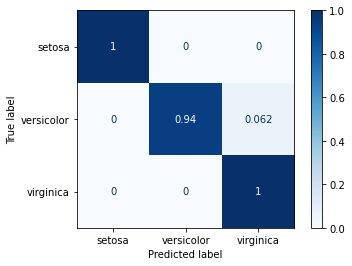

In [13]:
plot_confusion_matrix(pipe, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize="true")

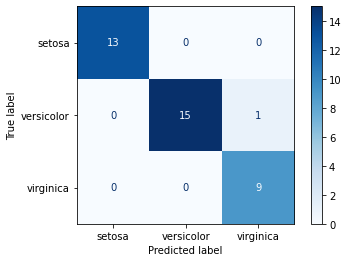

In [17]:
plot_confusion_matrix(pipe, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues)

In [18]:
accuracy_score(y_test, pipe.predict(X_test))

0.9736842105263158

Ahora con el modelo entrenado, persistimos el modelo.

In [19]:
from joblib import dump, load
dump(pipe, 'clasificador.joblib') 

['clasificador.joblib']

## Re-factorización

Con el modelo ya guardado procedemos a refactorizar el proceso para poder usarlo en un servicio web. Primero probamos que podemos cargar de manera correcta el modelo y usarlo nuevamente si necesidad de entrenarlo

In [20]:
clf = load('clasificador.joblib')
accuracy_score(y_test, clf.predict(X_test))

0.9736842105263158

Para crear el servicio web, las librerias más usadas son las siguientes:

1.  [Flask](https://flask.palletsprojects.com/en/1.1.x/)
2.  [FastAPI](https://fastapi.tiangolo.com/)

En este sesión vamos a ver como usar Flask conjunto a otras herramientas que tienen un poco mas de profundidad.

1. https://www.heroku.com/ : plataforma usada para publicar servicios web.
2. https://git-scm.com/downloads : para gestionar el versionamiento
3. https://gunicorn.org/ : Servidor HTTP

¡Comencemos!



1. Crear un cuenta en heroku: https://www.heroku.com/. Es gratis, requiere un correo. Se recibe un correo en donde se debe confirmar la cuenta y crear la contraseña.

2. Instalar Heroku Cli : https://devcenter.heroku.com/articles/heroku-cli#download-and-install

3. Instalar Git: https://git-scm.com/downloads

3.  Hacer login con heroku


```
heroku login -i
```



4. Crear una aplicación en Heroku: https://dashboard.heroku.com/apps

5. Crear la estructura de archivos como se muestra en esta carpeta del repositorio https://github.com/jdariasl/ML_2020/tree/master/Labs/Extra/despliegue_modelos

Vamos entender el contenido de estos archivos:
*   Templates: carpeta con los archivos HTML base para la aplicación
*   Procfile: Archivo para la configuración de Gunicorn
*   app.py: script con el codigo refactorizado para usar el modelo entrenado para realizar predicciones
*   requirements.txt: archivo especificando las dependencias










6. Descargar el modelo entrenado, y ponerlo en la misma estructura de carpeta a nivel del archivo `app.py`. Si hay lugar modificar el nombre del archivo en `app.py`.

7. Inicializar el repositorio git, dentro de la carpeta, **reemplazar con el nombre de la aplicación creada en el paso 4**.

```
git init

# reemplazar con el nombre de la aplicación creada
heroku git:remote -a test-ml-prd

# espeficar a heroku que se usa python

heroku buildpacks:set heroku/python

```





7. Publicar la aplicación: Adicionar los archivos, confirmar que vamos realizar el cambio y finalmente desplegarlos a la nube

```
git add .
git commit -am "deploying the model"
git push heroku master:main
```


## Rerencias y enlaces de interes


https://scikit-learn.org/stable/modules/model_persistence.html

https://www.snowflake.com/trending/machine-learning-engineer-vs-data-scientist
